# Bank Churn analysis
Dataset provided at location `data/BankChurners.csv`

# Load data

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle

In [3]:
path = os.path.join('data','BankChurners.csv')
df = pd.read_csv(path)

In [4]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 21
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,NaN
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,NaN
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,NaN
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,NaN
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

**Summary of raw data as imported:**
- We have over 10,000 rows, and 21 columns
- Columns:
  - CLIENTNUM probably just an id number, not likely to be informative.
  - Attrition_Flag is the dependent variable we are trying to predict (churn/non-churn etc)
  - Several columns like Gender, Marital status are really `categorical`, rather than `object` type.  Should look at label encoding the unique values.
  - There is an `Unnamed` column with 0 non-null values this can be safely dropped.
  - Lots of informative looking numerical features/columns to do with transaction stats.  Might be able to gain some information by engineering new features as combinations of these.


# Data cleaning
Tidy up data types, drop useless columns, check for nulls etc.

## Lowercase col names
Convert column names to lowercase to avoid mistakes.

In [6]:
df.columns = df.columns.str.lower()

## "unnamed" empty column
Drop the `Unnamed` column

In [7]:
df = df.drop(columns='unnamed: 21')

## attrition_flag (churn)
Replace attrition_flag with a boolean column called "churn" as True/False (for convenience)

In [8]:
df.loc[:,'churn'] = (df['attrition_flag'] == 'Attrited Customer').astype(int)
df = df.drop(columns='attrition_flag')
df.churn.value_counts()

0    8500
1    1627
Name: churn, dtype: int64

## Convert to categorical type
Convert to categorical type for efficiency and because ML models can't directly work with objects/strings, so these columns need to become encoded eventually anyway.

In [9]:
df.loc[:,'gender'] = df.gender.astype('category')
df.loc[:,'education_level'] = df.education_level.astype('category')
df.loc[:,'marital_status'] = df.marital_status.astype('category')
df.loc[:,'income_category'] = df.income_category.astype('category')
df.loc[:,'card_category'] = df.card_category.astype('category')

## Null values
If any, then we would need to consider an imputation strategy to deal with these

In [10]:
df.isna().sum()

clientnum                   0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
churn                       0
dtype: int64

In this case, there are zero null/NaN values.  All columns are populated for all 10,000 customer records so no imputation looks necessary.

However it looks like there might be some "unknown" data for income category

### marital_status
Check count of each category

In [33]:
df.marital_status.value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

There are 749 "unknowns" out of 10,000 records.  This is significant enough that we shouldn't just drop these records, we should try to fill these.

Let's use the strategy to impute using the most common category.

In [52]:
def fill_marital_status(df):
  '''Replace Unknown with Married.'''
  df.loc[:,'marital_status'] = df.marital_status.replace('Unknown','Married')
  return df

df = fill_marital_status(df)
df.marital_status.value_counts()

Married     5436
Single      3943
Divorced     748
Name: marital_status, dtype: int64

### Income_category

In [11]:
df.income_category.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: income_category, dtype: int64

There are even more "unknown" salary (1112).  

For now we will impute this simply using the "most_common" category (Less than \$40k).  

However income is likely to be quite linked to other features.  With more time we could impute this by grouped information on some of these demographic features. For future, in case we would come back to change this imputation strategy, let's identify some features we would group by.  Plot distributions vs income.

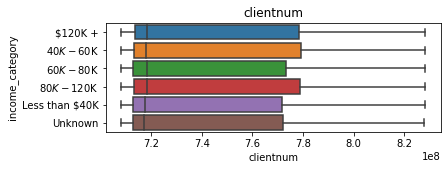

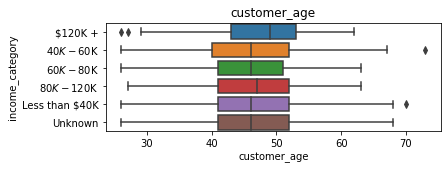

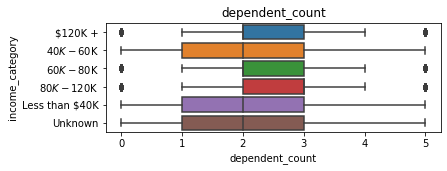

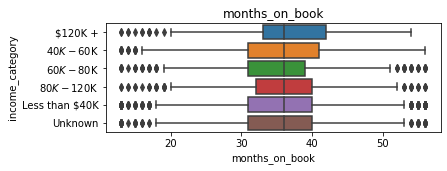

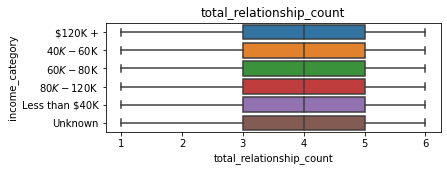

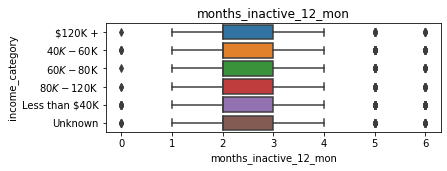

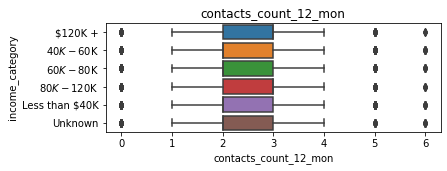

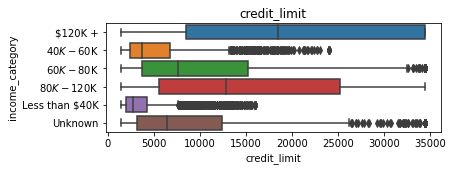

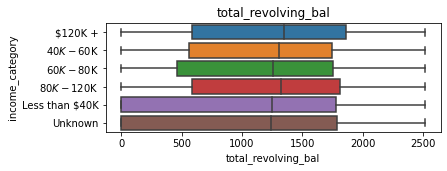

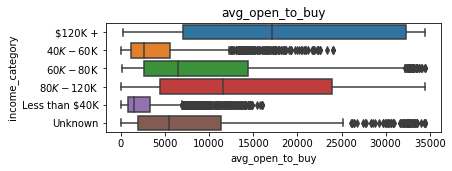

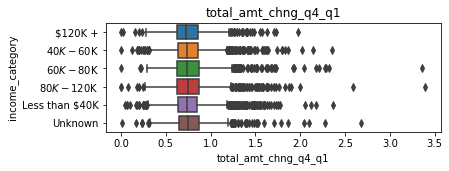

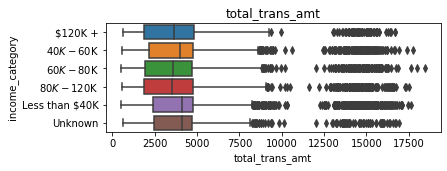

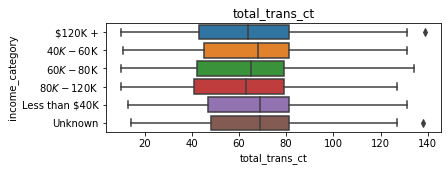

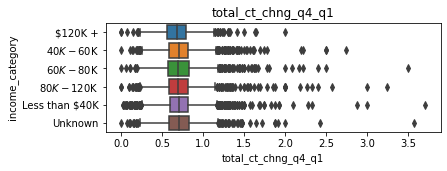

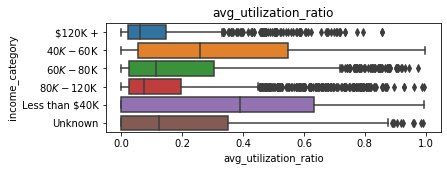

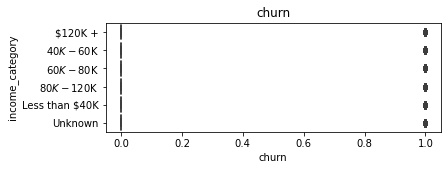

In [47]:
def plot_vs_income(df, col):
    '''Plot a side-by-side boxplot and histogram for both churn == 0 and 1'''
    fig = plt.figure()
    fig.set_size_inches(6,2)
    ax = fig.add_subplot()
    sns.boxplot(data=df, x=col, y='income_category', orient='h', ax=ax);
    ax.set_title(f'{col}')
    
for col in df.select_dtypes(np.number):
    plot_vs_income(df, col)

Good candidates for the grouping and imputation on income_category could be: age, credit_limit.  However, more time and care would need to be taken to ensure this doesn't needlessly bias the model training later.

So for now just replace all Unknowns using the most_common value

In [230]:
def fill_incomes(df):
  '''Replace Unknown with "less than 40k".'''
  df.loc[:,'income_category'] = df.income_category.replace('Unknown','Less than $40K')
  return df

df = fill_incomes(df)
df.income_category.value_counts()

AttributeError: 'Series' object has no attribute 'income_category'

# Exploratory analysis

## Basic statistics

In [56]:
df.describe().round(1)

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn
count,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0
mean,739177606.3,46.3,2.3,35.9,3.8,2.3,2.5,8632.0,1162.8,7469.1,0.8,4404.1,64.9,0.7,0.3,0.2
std,36903783.5,8.0,1.3,8.0,1.6,1.0,1.1,9088.8,815.0,9090.7,0.2,3397.1,23.5,0.2,0.3,0.4
min,708082083.0,26.0,0.0,13.0,1.0,0.0,0.0,1438.3,0.0,3.0,0.0,510.0,10.0,0.0,0.0,0.0
25%,713036770.5,41.0,1.0,31.0,3.0,2.0,2.0,2555.0,359.0,1324.5,0.6,2155.5,45.0,0.6,0.0,0.0
50%,717926358.0,46.0,2.0,36.0,4.0,2.0,2.0,4549.0,1276.0,3474.0,0.7,3899.0,67.0,0.7,0.2,0.0
75%,773143533.0,52.0,3.0,40.0,5.0,3.0,3.0,11067.5,1784.0,9859.0,0.9,4741.0,81.0,0.8,0.5,0.0
max,828343083.0,73.0,5.0,56.0,6.0,6.0,6.0,34516.0,2517.0,34516.0,3.4,18484.0,139.0,3.7,1.0,1.0


**Summary**
- Mean of:
  - Age is 46
  - Dependents is 2
  - Months on book is 36
  - relationship count is 4
  - Months inactive in last year is 2
  - contacts in last year is 3
  - Credit limit is \$8,632
  - Revolving balance is \$1,162
  - Change in transaction amnt between Q4-Q1 is 0.8
  - Total transaction amnt is \$4,404
  - Total transaction count is 65
  - Change in transaction count between Q4-Q1 is 0.7
  - Card utilisation ratio is 0.3
  - Churn is 0.2 (which means 20%, *rounded*) of the customer records are for churned customers.

Check more precisely what proportion of the data is for churned customers

In [57]:
df.churn.mean().round(3) * 100

16.1

So actually 16.1% of the data is for customers who have churned (inactive/have left the bank).

**That's quite a large class imbalance**, we will have to be mindful of this when training a prediction model.

Let's look at some general summary stats for categorical features

In [58]:
df.describe(exclude=np.number, include='category')

,gender,education_level,marital_status,income_category,card_category
count,10127,10127,10127,10127,10127
unique,2,7,3,5,4
top,F,Graduate,Married,Less than $40K,Blue
freq,5358,3128,5436,4673,9436


So this bank's customer base mostly comprises of:
- Females (out of 2 categories, representing over 1/2 of customer-base)
- Graduate level education (out of 7 categories, 1/3rd of the customer-base)
  - *Seems like a large bias towards grads.*
- Married (out of 4 categories, just less than half of customer-base
  - *Also seems strongly biased towards married people.*
- Incomes of less than \$40k (out of 6 categories)
  - *Again strong bias towards incomes less than \$40k.*
- Blue card customers (out of 4 categories, almost 95% of customer base!)
  - *Heavily biased towards blue card holders.  Must be the standard option.*

## Scatter matrix

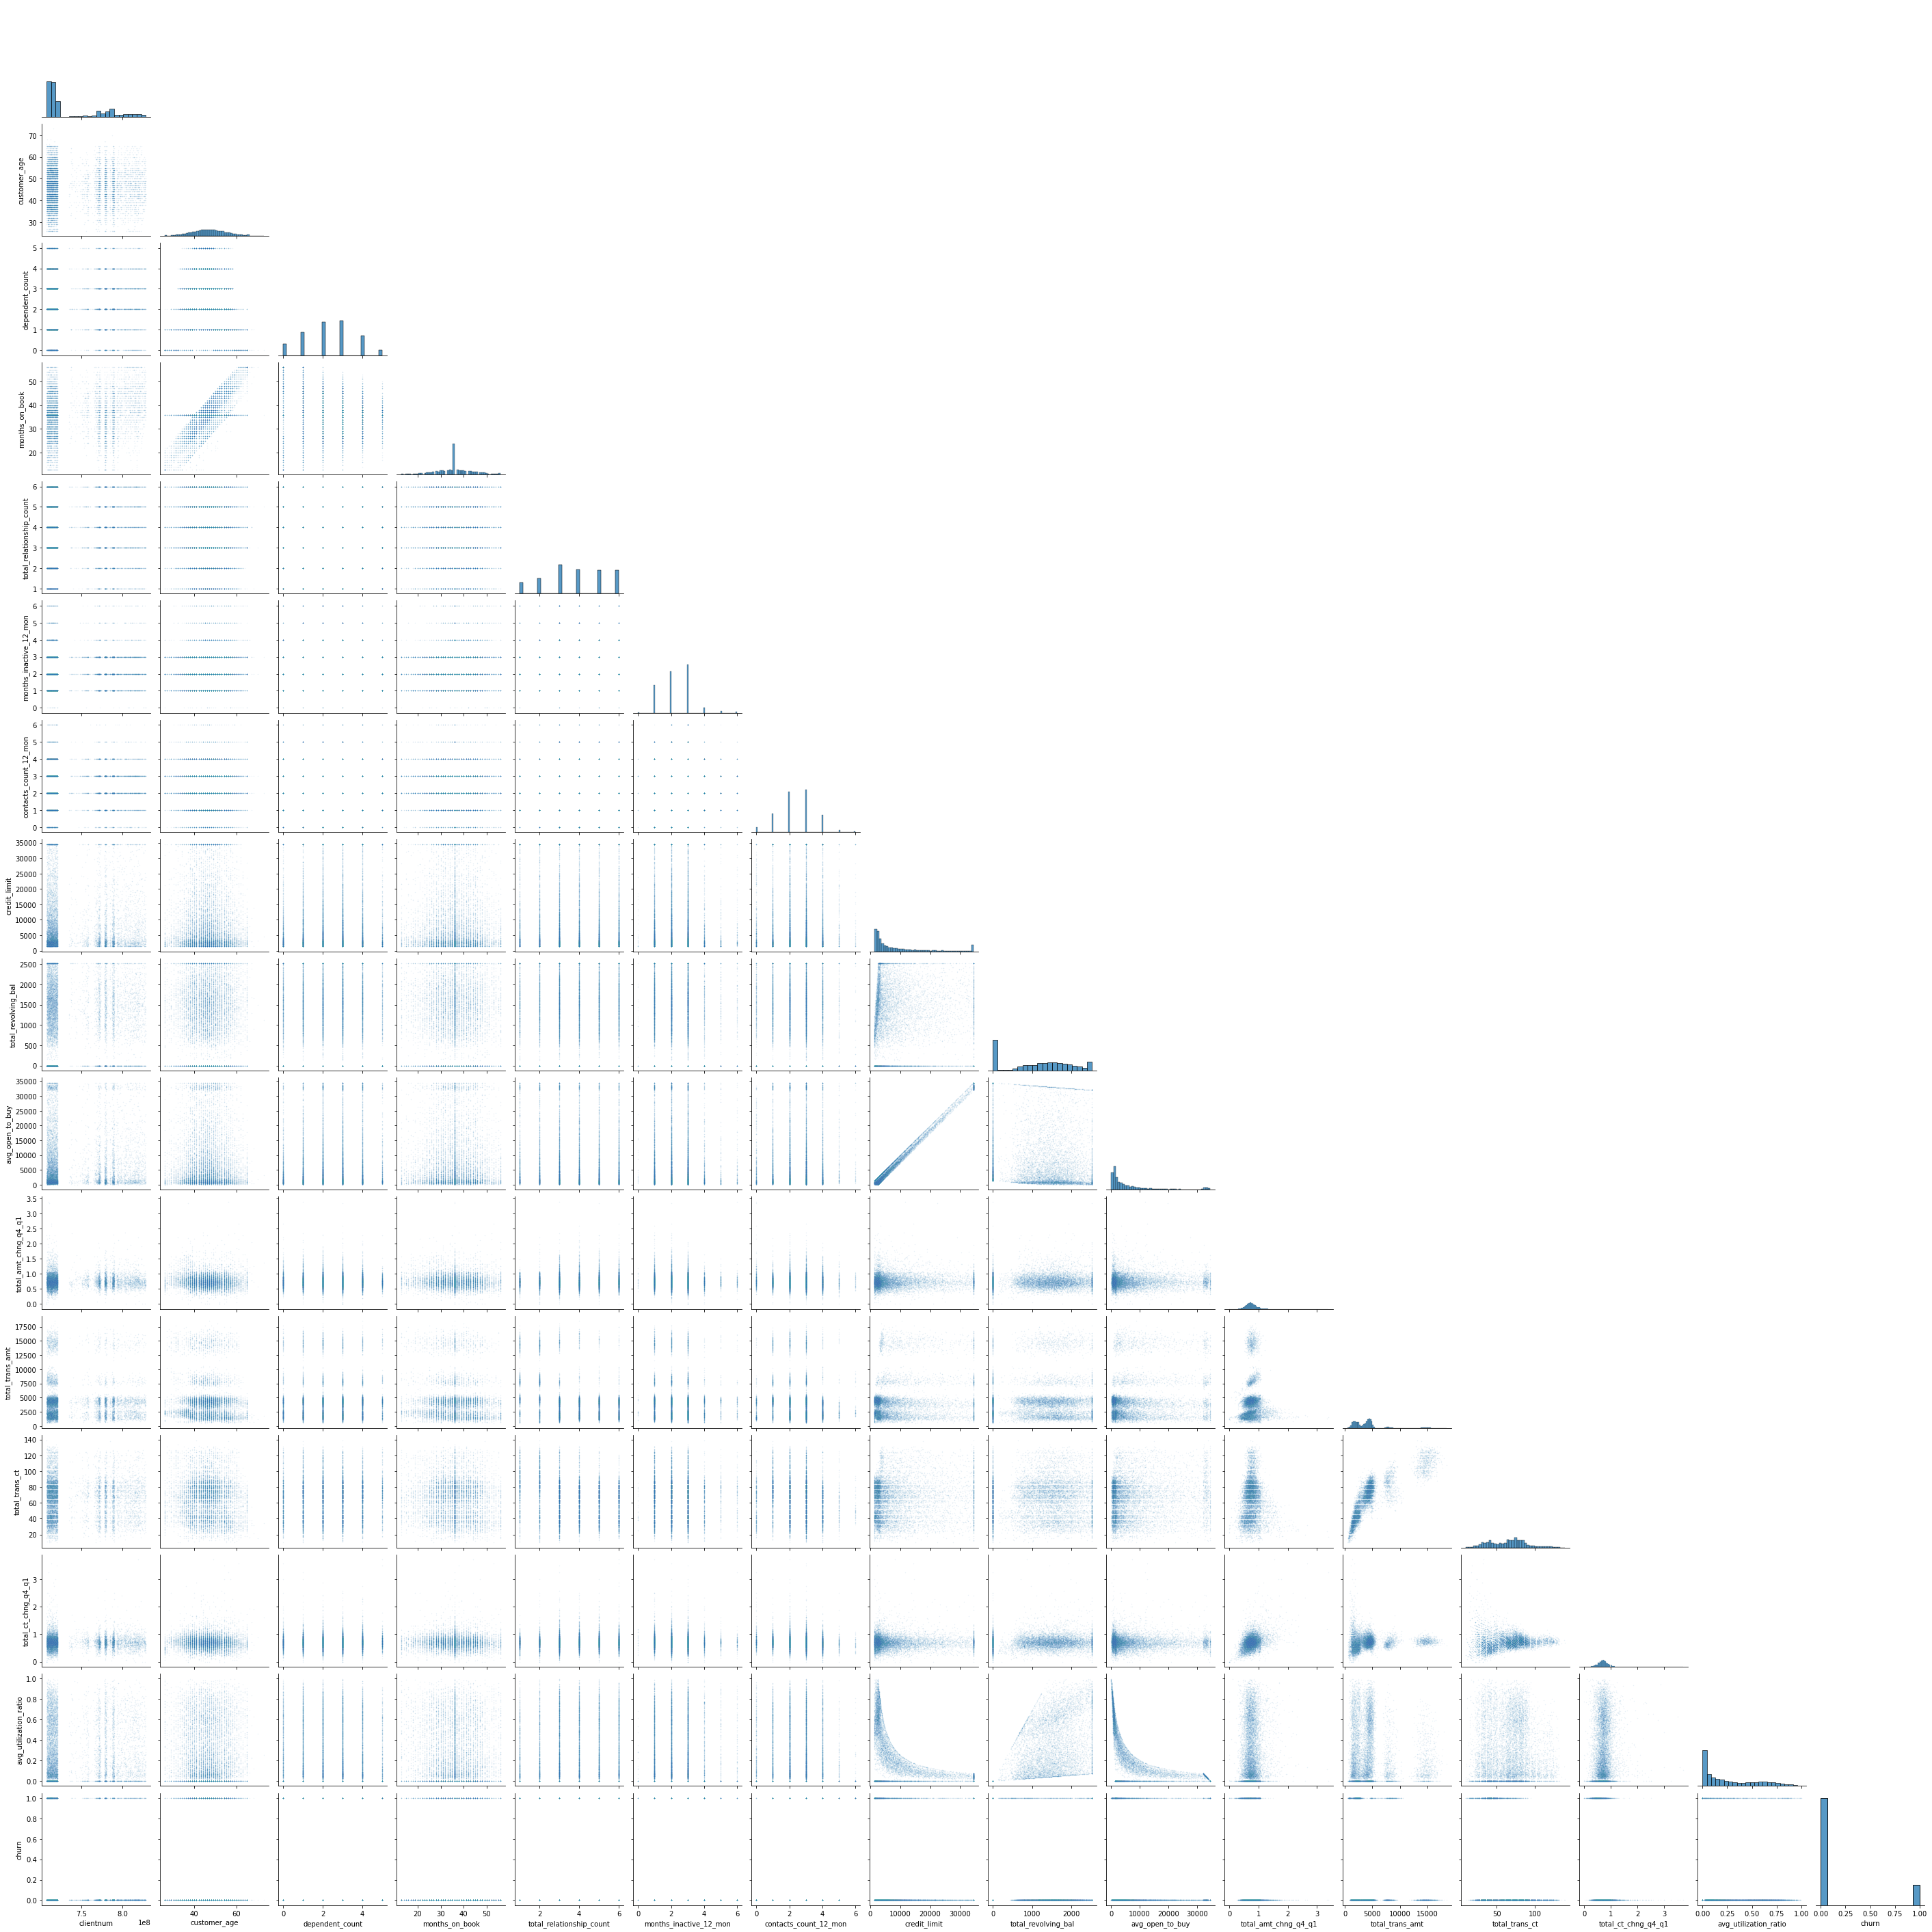

In [17]:
sns.pairplot(df, plot_kws={'alpha':0.1, 's':2}, corner=True);

Really hard to see much as the matrix of plots is so dense, but zooming in showed the following highlights:
- clientnum has no obvious correlation to any other parameters. No clear influence on churn.  *Though there seems to be a large number of small values and large values for client id, but not so many in between. Interesting, but probably not very informative.*
- customer_age looks quite normally distributed, with peak just over 40.
- dependent_count also looks normally distributed, peaking between 2 and 3 dependents.
- months_on_book histogram is poorly scaled but looks normal, with an unusual spike at around 35months. Was there some large promotional drive 30months ago that explains this?
- total_relationship count is reasonably uniform rather than normal, between 

## Correlation matrix
Pearson correlation matrix

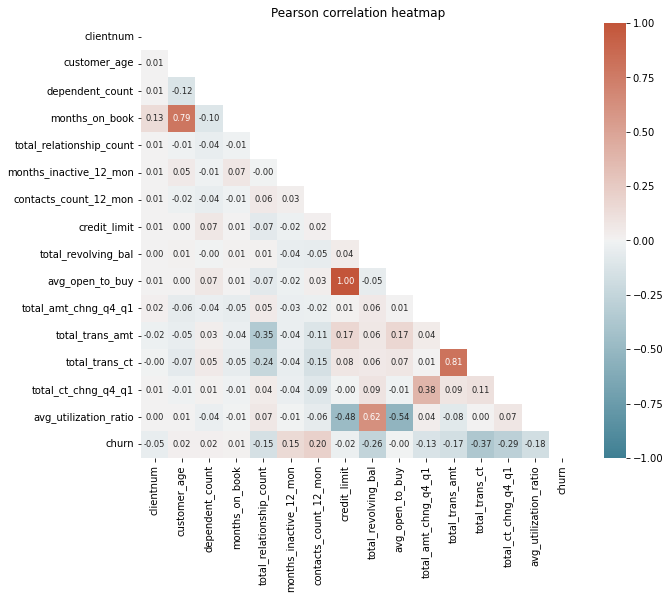

In [59]:
# Plot with mask for triangle plot only
def plot_corr_matrix(df):
    '''Plots formatted correlation matrix for the supplied df.'''
    fig = plt.figure()
    fig.set_size_inches(10,8)
    ax = fig.add_subplot()

    corr_mat = df.corr()
    mask = np.triu(corr_mat)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr_mat, square=True, mask=mask, cmap=cmap, 
                annot=True, fmt='.2f', vmin=-1, vmax=1,
                annot_kws={'fontsize':'small'},
                ax=ax);
    ax.set_title('Pearson correlation heatmap');
    return corr_mat
    
corr_mat = plot_corr_matrix(df)

**Summary of correlations:**
- Strong correlation coeffs observed between:
  - months_on_book vs customer_age
  - total_trans_amt vs total_relationship_count
  - total_trans_ct vs total_relationship_count
  - avg_open_to_buy vs credit_limit 
    - **Very co-linear**, makes sense as customers with high credit-limit are probably the ones who are quire open to having even more credit.*
  - avg_utilisation_ratio vs credit_limit
  - avg_utilisation_ratio vs total_revolving_bal
  - avg_utilisation_ratio vs avg_open_to_buy
  - total_ct_chng_q4_q1 vs total_amt_chng_q4_q1
    - These 2 features are inter-related, so makes sense to be highly positive correlation.
  - total_transaction_ct vs total_trans_amt
    - Again these 2 features are inter-related, so makes sense to be highly positive correlation.
    
For clarity, print out a list of correlation coeffs vs the dependent variable "churn"

In [22]:
corr_mat['churn'].sort_values(ascending=False)

churn                       1.000000
contacts_count_12_mon       0.204491
months_inactive_12_mon      0.152449
dependent_count             0.018991
customer_age                0.018203
months_on_book              0.013687
avg_open_to_buy            -0.000285
credit_limit               -0.023873
clientnum                  -0.046430
total_amt_chng_q4_q1       -0.131063
total_relationship_count   -0.150005
total_trans_amt            -0.168598
avg_utilization_ratio      -0.178410
total_revolving_bal        -0.263053
total_ct_chng_q4_q1        -0.290054
total_trans_ct             -0.371403
Name: churn, dtype: float64

**Top few correlations vs churn (sorted by coefficient):**
- total_trans_ct (-ve correlation)
- total_ct_chng_q4_q1 (-ve correlation)
- total_revolving_bal (-ve correlation)
- contacts_count_12_mon (+ve correlation)
- avg_utilization_ratio (-ve correlation)
- months_inactive_12_mon (+ve correlation)
- **Summary**
  - Negative correlations with features that represent "usage of credit".
  - Positive correlations with features that represent "lack of usage of credit".

## Numerical features, a closer look

In [60]:
df_num = df.select_dtypes(include=['int','float'])
df_num.columns.tolist()

['clientnum',
 'customer_age',
 'dependent_count',
 'months_on_book',
 'total_relationship_count',
 'months_inactive_12_mon',
 'contacts_count_12_mon',
 'credit_limit',
 'total_revolving_bal',
 'avg_open_to_buy',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_trans_ct',
 'total_ct_chng_q4_q1',
 'avg_utilization_ratio',
 'churn']

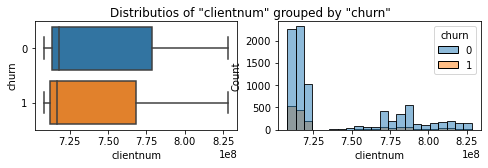

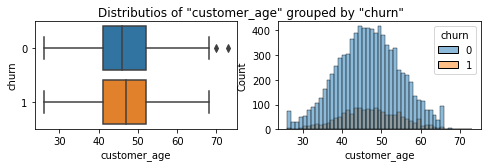

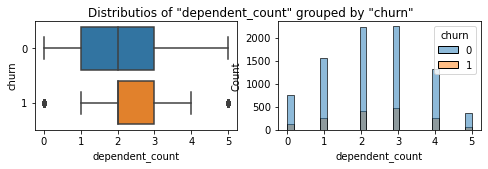

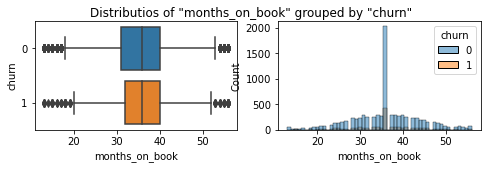

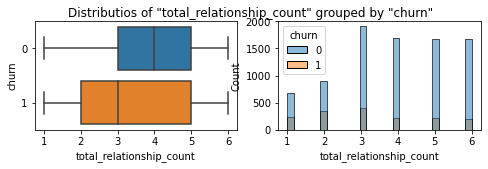

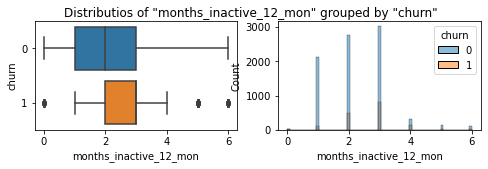

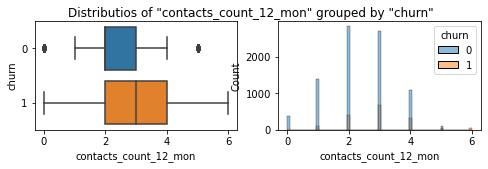

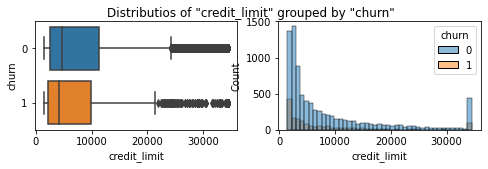

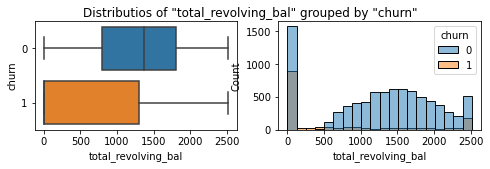

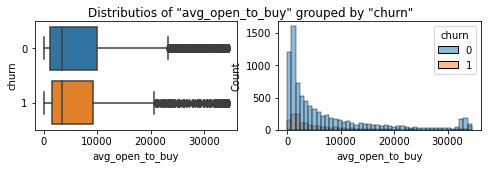

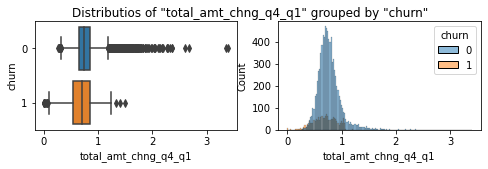

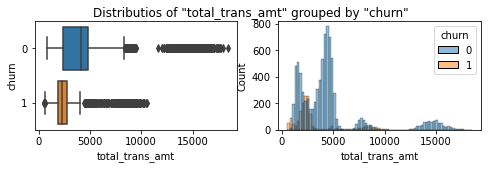

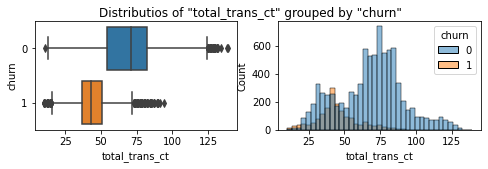

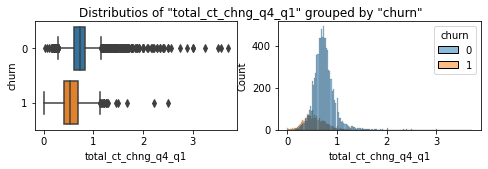

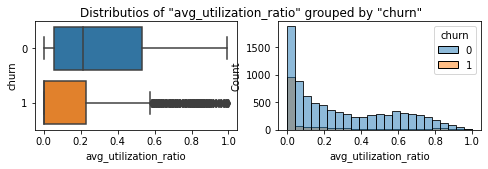

In [61]:
def plot_vs_churn(df, col):
    '''Plot a side-by-side boxplot and histogram for both churn == 0 and 1'''
    fig = plt.figure()
    fig.set_size_inches(8,2)
    ax = fig.add_subplot(1,2,1)
    sns.boxplot(data=df, x=col, y='churn', orient='h');

    ax = fig.add_subplot(1,2,2)
    sns.histplot(data=df, x=col, hue='churn');
    fig.suptitle(f'Distributios of "{col}" grouped by "churn"')
    
for col in df_num.columns:
    if col == 'churn': continue
    plot_vs_churn(df, col)

## Categorical features

In [62]:
df.select_dtypes(include=['category'])

,gender,education_level,marital_status,income_category,card_category
0,M,High School,Married,$60K - $80K,Blue
1,F,Graduate,Single,Less than $40K,Blue
2,M,Graduate,Married,$80K - $120K,Blue
3,F,High School,Married,Less than $40K,Blue
4,M,Uneducated,Married,$60K - $80K,Blue
...,...,...,...,...,...
10122,M,Graduate,Single,$40K - $60K,Blue
10123,M,Unknown,Divorced,$40K - $60K,Blue
10124,F,High School,Married,Less than $40K,Blue
10125,M,Graduate,Married,$40K - $60K,Blue


In [63]:
df[df.churn == 1].describe(include='category')

,gender,education_level,marital_status,income_category,card_category
count,1627,1627,1627,1627,1627
unique,2,7,3,5,4
top,F,Graduate,Married,Less than $40K,Blue
freq,930,487,838,799,1519


In [64]:
df[df.churn == 0].describe(include='category')

,gender,education_level,marital_status,income_category,card_category
count,8500,8500,8500,8500,8500
unique,2,7,3,5,4
top,F,Graduate,Married,Less than $40K,Blue
freq,4428,2641,4598,3874,7917


In [65]:
def categorywise_churn_rate(df, col, verbose=False):
    '''Print the churn rate for each category in a given categorical column.  Also returns a dict'''
    groups = df.groupby(col)
    churn_rates = dict()
    for name, group in groups:
        churn_rate = group.churn.mean().round(3)*100
        if verbose: print(f'In feature:{col:<20} category:{name:<15} has a churn_rate:{churn_rate:.1f}%')
        churn_rates[name] = churn_rate
        
    return churn_rates

for col in ['gender','education_level','marital_status','income_category','card_category']:
    churn_rates_gender = categorywise_churn_rate(df, col, verbose=True)
    print('-'*60)

In feature:gender               category:F               has a churn_rate:17.4%
In feature:gender               category:M               has a churn_rate:14.6%
------------------------------------------------------------
In feature:education_level      category:College         has a churn_rate:15.2%
In feature:education_level      category:Doctorate       has a churn_rate:21.1%
In feature:education_level      category:Graduate        has a churn_rate:15.6%
In feature:education_level      category:High School     has a churn_rate:15.2%
In feature:education_level      category:Post-Graduate   has a churn_rate:17.8%
In feature:education_level      category:Uneducated      has a churn_rate:15.9%
In feature:education_level      category:Unknown         has a churn_rate:16.9%
------------------------------------------------------------
In feature:marital_status       category:Divorced        has a churn_rate:16.2%
In feature:marital_status       category:Married         has a churn_rate:15.4

Features with high variation in churn rates between categories are:
- card_category (Platinum customers almost 10% more likely to churn than Blue customers)
- education_level (Doctorate holders were almost 6% more likely to churn than Graduates)

Other observations:
- marriage_status of "unknown" shouldn't be imputed with the most_common value "married" because the churn rates are not representative of that category, it would influence the model.  Anyway marriage status isn't a powerful predictor (only affects a few % churn rate), so might still use this imputation method for completeness of the final model.

With more time, it would be better to display the above info using a pivot table instead.

# Feature engineering

## Adding linear combinations of numerical features

### Tenure / age

In [66]:
df.loc[:,'tenure_per_age'] = df.months_on_book / (df.customer_age * 12)

### Utilisation / age

In [67]:
df.loc[:,'utilisation_per_age'] = df.avg_utilization_ratio / df.customer_age

### credit limit / age

In [68]:
df.loc[:,'credit_lim_per_age'] = df.credit_limit / df.customer_age

### total transactions / credit limit

In [69]:
df.loc[:,'total_trans_amt_per_credit_lim'] = df.total_trans_amt / df.credit_limit
df.loc[:,'total_trans_ct_per_credit_lim'] = df.total_trans_ct / df.credit_limit

### Polynomial features - sklearn
This is just experimental, these features are not used in modelling yet as they probably introduce massive redundancy and multicolinearity into the model, but might we a way of sqeezing a bit more performance out.

In [70]:
from sklearn.preprocessing import PolynomialFeatures

cols = ['customer_age','dependent_count','months_on_book',
        'total_relationship_count','months_inactive_12_mon',
        'contacts_count_12_mon','credit_limit','total_revolving_bal',
        'avg_open_to_buy','total_amt_chng_q4_q1','total_trans_amt','total_trans_ct',
        'total_ct_chng_q4_q1','avg_utilization_ratio']

poly = PolynomialFeatures(2, include_bias=False)
poly_feats = poly.fit_transform(df[cols])
df_poly = pd.DataFrame(poly_feats, columns=poly.get_feature_names_out())
df_poly.loc[:,'churn'] = df.churn

In [71]:
# Print the top 10 values by (absolute) correlation coef
df_poly.corr()['churn'].abs().sort_values(ascending=False)[1:11]

total_trans_ct total_ct_chng_q4_q1         0.410125
total_trans_ct                             0.371403
total_amt_chng_q4_q1 total_trans_ct        0.351964
total_trans_ct^2                           0.344728
customer_age total_trans_ct                0.334682
total_relationship_count total_trans_ct    0.328217
total_revolving_bal total_trans_ct         0.319486
months_on_book total_trans_ct              0.313826
total_revolving_bal total_ct_chng_q4_q1    0.299294
total_ct_chng_q4_q1                        0.290054
Name: churn, dtype: float64

## Final cleaning - Dropping clientnum

In [ ]:
df = df.drop(columns='clientnum')

## Final EDA - check correlations of engineered features

In [73]:
# Use function written earlier
cols = ['churn', 'tenure_per_age', 'utilisation_per_age', 'credit_lim_per_age',
       'total_trans_amt_per_credit_lim','total_trans_ct_per_credit_lim']
df[cols].corr()['churn'].sort_values(ascending=False)

churn                             1.000000
tenure_per_age                    0.000465
credit_lim_per_age               -0.029887
total_trans_ct_per_credit_lim    -0.132511
total_trans_amt_per_credit_lim   -0.133222
utilisation_per_age              -0.171645
Name: churn, dtype: float64

Utilisation per age has a reasonable correlation coef, though basically not much more than the raw utilisation colum itself

# Final preprocessing function

In [232]:
def preprocess_raw(df):
    df.columns = df.columns.str.lower()
    
    df = df.drop(columns='unnamed: 21')
    
    df.loc[:,'churn'] = (df['attrition_flag'] == 'Attrited Customer').astype(int)
    df = df.drop(columns='attrition_flag')
    df.churn.value_counts()
    
    df.loc[:,'gender'] = df.gender.astype('category')
    df.loc[:,'education_level'] = df.education_level.astype('category')
    df.loc[:,'marital_status'] = df.marital_status.astype('category')
    df.loc[:,'income_category'] = df.income_category.astype('category')
    df.loc[:,'card_category'] = df.card_category.astype('category')
    
    df = fill_marital_status(df)
    
    df = fill_incomes(df)

    df.loc[:,'tenure_per_age'] = df.months_on_book / (df.customer_age * 12)
    df.loc[:,'utilisation_per_age'] = df.avg_utilization_ratio / df.customer_age
    df.loc[:,'credit_lim_per_age'] = df.credit_limit / df.customer_age
    df.loc[:,'total_trans_amt_per_credit_lim'] = df.total_trans_amt / df.credit_limit
    df.loc[:,'total_trans_ct_per_credit_lim'] = df.total_trans_ct / df.credit_limit
    
    df = df.drop(columns='clientnum')
    
    return df

# Check the preprocessing is workingwith a temporary df
df = preprocess_raw(pd.read_csv(path))

# Modelling

In [242]:
# Imports, to be tidied up at end
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.base import TransformerMixin, BaseEstimator

## Setting up train_test data
We will split the dataset to 80% training and 20% testing sets to allow final validation of the result.

Generally for this dataset, we have a reasonably large number of records relative to the number of features, so the splitting strategy will be as follows:
- 20% testing set (will be held out until final model evaluation)
- 80% training set
  - *Models will be trained on the 80% training set whilst also using 5-fold cross-validation, this will ensure a well generalised result that does not over-fit to the training set.*
- Once the final model is selected, it will be retrained over the full 100% training set before deployment.  This will ensure all information in the original dataset has a chance to be learned by the model.

In [243]:
X = df.drop(columns='churn')
y = df.churn

# Check shape of X and y
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (10127, 24)
y shape is (10127,)


In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shape of train and test sets
print(f'X_train shape is {X_train.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_test shape is {y_test.shape}')

X_train shape is (8101, 24)
X_test shape is (2026, 24)
y_train shape is (8101,)
y_test shape is (2026,)


## Baseline model
The dummy classifier just blindly predicts the most-common class in the training data (churn == False).  

In [245]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.8385982230997039

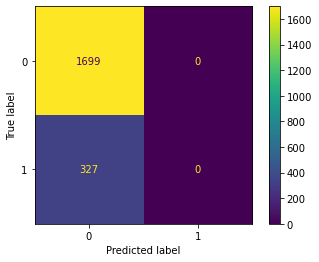

In [246]:
ConfusionMatrixDisplay.from_estimator(dummy_clf, X_test, y_test);

The confusion matrix shows 0 predictions for churn == True, which resulted in 1699 "true negatives" and only 327 "false negatives".  This shows why accuracy score is a poor metric for biased classification problems.

## Construct preprocessing Pipeline

**Numerical features**  
Include an imputation step for numerical features, even though there are no NaN values in this dataset, it is a good practice in-case the training is re-run on data with NaN values.  Use a "median" imputation strategy as this is a good baseline, not too skewed by outliers.

**Categorical features**  
Use onehot encoding for categorical features.  Will probably try ordinal encoder on some features, as they have a certain "order" to them (like income values).

In [268]:
'''Define a custom transformer as a wrapper for ordinal encoder, as 
get_feature_names_out method isn't implemented as standard'''

class OrdinalEncoder_custom(TransformerMixin, BaseEstimator):
    '''wraps OrdinalEncoder to enable .get_feature_names_out() method.'''
    def __init__(self, categories='auto'):
        self.categories = categories
        self.encoder = OrdinalEncoder(categories=categories)
    
    def fit(self, x, y=None):
        self.encoder.fit(X, y)
        self.feature_names = X.columns.tolist()
        return self
    
    def transform(self, X, y=None):
        return self.encoder.transform(X)
        
    def fit_transform(self, X, y=None):
        self.feature_names = X.columns.tolist()
        return self.encoder.fit_transform(X, y)

    def get_feature_names_out(self):
            return self.feature_names

In [269]:
# Numerical preprocessor
num_features = X_train.select_dtypes(include=['int','float']).columns.tolist()
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

# Ordinal features
ord_features = ['education_level']
ord_transformer = OrdinalEncoder_custom(categories=[['Unknown','Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']])

# Categorical preprocessor
cat_features = ['gender', 'marital_status', 'income_category', 'card_category']
cat_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Combined preprocessor
preprocessor = ColumnTransformer([('ords', ord_transformer, ord_features),
                                  ('cats', cat_transformer, cat_features),
                                  ('nums', num_transformer, num_features)],
                                 remainder='drop')

## Model evaluation funcs

In [270]:
def evaluate_clf(clf,clf_name):
    '''Compute a dict of metrics for easy comparison of various models.'''
    start = time.time()
    clf.fit(X_train,y_train);
    end = time.time()
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)
    cv_scores = cross_val_score(clf,X,y, cv=5)

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(10,4)
    fig.suptitle(f'Name: {clf_name}')
    plt.tight_layout()
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=axs[0]);
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axs[1]);
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=axs[2]);

    acc_train = accuracy_score(y_train,y_train_pred)
    acc_test = accuracy_score(y_test,y_test_pred)

    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_proba[:,1])
    axs[0].set_title('Precision-Recall curve')
    axs[1].set_title('ROC curve')

    eval_dict = {'modelname':clf_name,
                'acc_train':acc_train,
                'acc_test':acc_test,
                'precision':precision,
                'recall':recall,
                'f1':f1,
                'auc':auc,
                'cv_mean':cv_scores.mean(),
                'cv_std':cv_scores.std(),
                'training_time':(end-start)}
    return eval_dict

model_metrics = pd.DataFrame(columns=['modelname', 'acc_train', 'acc_test', 
                                      'precision', 'recall', 'f1', 'auc', 
                                      'cv_mean', 'cv_std','training_time'])

## Model training

### Logistic regression model

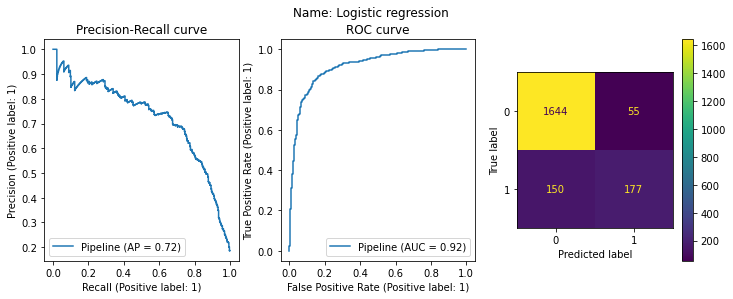

In [271]:
logreg_clf = Pipeline([('preprocessor', preprocessor),
                       ('logreg', LogisticRegression(max_iter=1000))])
       
# Evaluate
metrics = evaluate_clf(logreg_clf,'Logistic regression')
model_metrics = model_metrics.append(metrics, ignore_index=True)

### SGD logistic regression

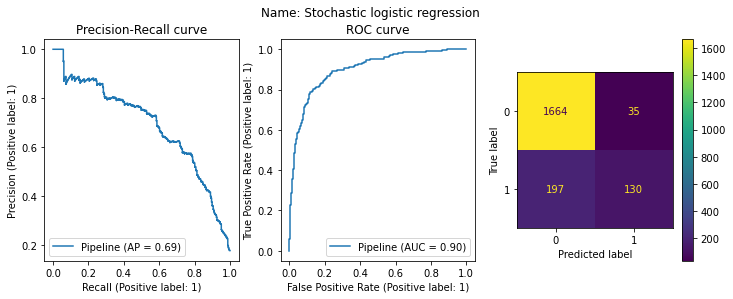

In [272]:
sgdlogreg_clf = Pipeline([('preprocessor', preprocessor),
                          ('sgdlogreg', SGDClassifier(loss='log'))])
                       
# Evaluate
metrics = evaluate_clf(sgdlogreg_clf,'Stochastic logistic regression')
model_metrics = model_metrics.append(metrics, ignore_index=True)

Marginally poorer result than vanilla logistic regression (with no tuning)

### Decision Tree

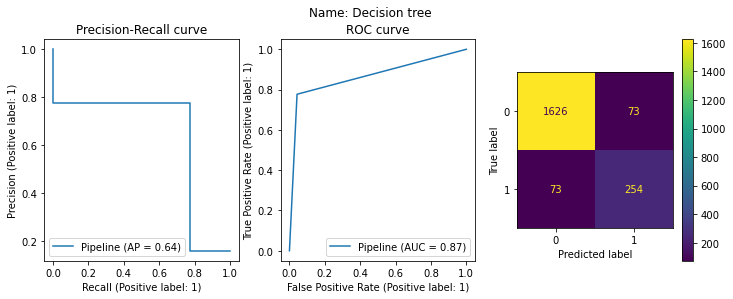

In [273]:
tree_clf = Pipeline([('preprocessor', preprocessor),
                     ('tree', DecisionTreeClassifier())])
                       
# Evaluate
metrics = evaluate_clf(tree_clf,'Decision tree')
model_metrics = model_metrics.append(metrics, ignore_index=True)

Marginally better result than baseline logistic regression

### Random forrest

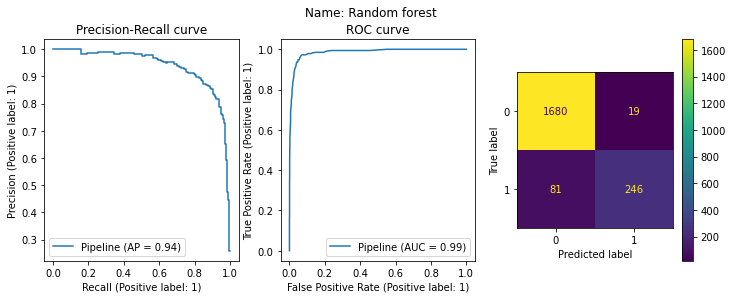

In [274]:
forest_clf = Pipeline([('preprocessor', preprocessor),
                       ('forest', RandomForestClassifier())])
                       
# Evaluate
metrics = evaluate_clf(forest_clf,'Random forest')
model_metrics = model_metrics.append(metrics, ignore_index=True)

Best result so far

### XGBoost

In [275]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

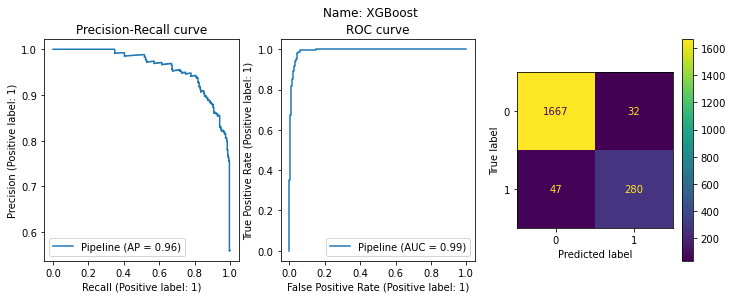

In [276]:
xgb_clf = Pipeline([('preprocessor', preprocessor),
                    ('xgbclf', XGBClassifier(eval_metric='logloss', use_label_encoder=False))])
                       
# Evaluate
metrics = evaluate_clf(xgb_clf,'XGBoost')
model_metrics = model_metrics.append(metrics, ignore_index=True)

Extremely high accuracy result!

## Model evaluation

In [277]:
model_metrics = model_metrics.set_index('modelname')

In [278]:
model_metrics

,acc_train,acc_test,precision,recall,f1,auc,cv_mean,cv_std,training_time
modelname,,,,,,,,,
Logistic regression,0.906925,0.898815,0.762931,0.541284,0.633274,0.917568,0.866210,0.073263,0.097174
Stochastic logistic regression,0.899395,0.885489,0.787879,0.397554,0.528455,0.901273,0.857522,0.082192,0.102179
Decision tree,1.000000,0.927937,0.776758,0.776758,0.776758,0.866896,0.890696,0.054043,0.114623
Random forest,1.000000,0.950642,0.928302,0.752294,0.831081,0.985702,0.920807,0.047321,0.951958
XGBoost,1.000000,0.961007,0.897436,0.856269,0.876369,0.992519,0.930977,0.050769,0.544367


### Accuracy

In [279]:
model_metrics.acc_test.sort_values(ascending=False)

modelname
XGBoost                           0.961007
Random forest                     0.950642
Decision tree                     0.927937
Logistic regression               0.898815
Stochastic logistic regression    0.885489
Name: acc_test, dtype: float64

Untuned XGboost model achieved highest accuracy on the 20% testing set of 96%

### f1-score

In [280]:
model_metrics.f1.sort_values(ascending=False)

modelname
XGBoost                           0.876369
Random forest                     0.831081
Decision tree                     0.776758
Logistic regression               0.633274
Stochastic logistic regression    0.528455
Name: f1, dtype: float64

Again, untuned xgboost achieved the highest f1 score.

### Training time

In [281]:
model_metrics.training_time.sort_values(ascending=True)

modelname
Logistic regression               0.097174
Stochastic logistic regression    0.102179
Decision tree                     0.114623
XGBoost                           0.544367
Random forest                     0.951958
Name: training_time, dtype: float64

Stochastic gradient descent was clearly the most computationally efficient classifier.  If scaling to large datasets we could tune this model to see if it can compete with the others in accuracy etc.

SGD and XGBoost can both be parallelised well for distributed computing / out-of-core model training if the dataset was much much larger.  For absolute maximum training performance a tuned SGD model might be the preferred choice.

The above times are also for the model fitting/training process.  Inference time will be less.

## Model tuning
With more time I would use GridSearchCV from sklearn, in a coarse and then a fine hyperparameter search.

The XGBoost classifier starts from a high level of accuracy already so it is currently the best trained model anyway

One thing to consider is that this model is most likely going to be used to focus promotional offers etc to try to prevent high risk-of-churn customers from leaving.  If it's things like sending out some focussed marketing materials etc, then the cost of false positives is relatively low.  We could consider adjusting the deision threshold on the best model, to ensure we don't get any false positives, but at the risk of some false negatives.

## Feature importances
With more time, I would expand this section to study feature imporances in the best tuned model

In [282]:
xgb_clf['xgbclf'].feature_importances_
# xgb_clf['preprocessor'].transformers[0][1].get_feature_names_out()

array([0.00756638, 0.02990756, 0.        , 0.04654377, 0.02071823,
       0.00673136, 0.00273623, 0.005522  , 0.00941661, 0.01785042,
       0.00816485, 0.00609075, 0.        , 0.        , 0.00881975,
       0.04098234, 0.00921192, 0.0079865 , 0.10142594, 0.04193678,
       0.02797873, 0.01124003, 0.1572573 , 0.01917841, 0.0275112 ,
       0.05151122, 0.20476976, 0.04689432, 0.01600644, 0.0098511 ,
       0.00784719, 0.01429686, 0.01802225, 0.01602373], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

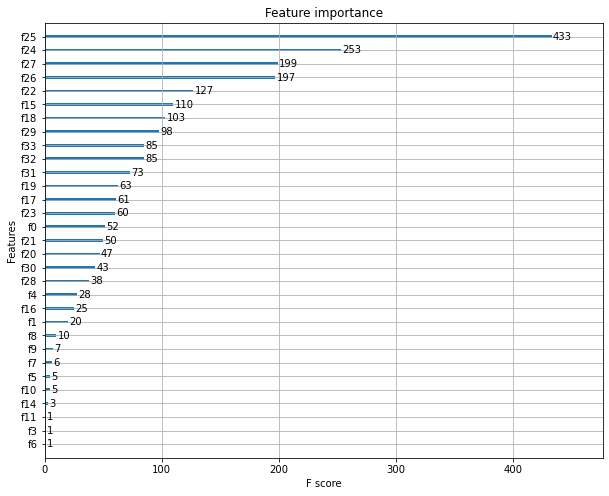

In [283]:
fig = plt.figure()
fig.set_size_inches(10,8)
ax = fig.add_subplot()
plot_importance(xgb_clf['xgbclf'], ax=ax)

## Save best model to disk

In [284]:
with open('model.pkl','wb') as f:
    pickle.dump(xgb_clf, f)

## Test exported model loads properly

In [285]:
with open('model.pkl','rb') as f:
    clf = pickle.load(f) 

In [286]:
clf.predict(X_test).mean()

0.1539980256663376